Premature end of JPEG file


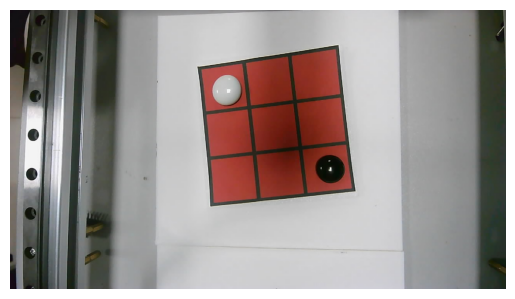

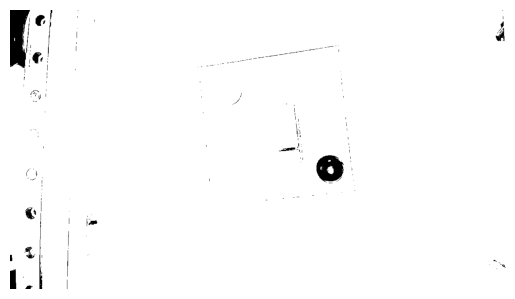

None


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

white_lower = np.array([200, 200, 200], dtype="uint8")
white_upper = np.array([255, 255, 255], dtype="uint8")
red_lower = np.array([0, 0, 100], dtype="uint8")
red_upper = np.array([100, 100, 255], dtype="uint8")
black_lower = np.array([0, 0, 0], dtype="uint8")
black_upper = np.array([40, 40, 40], dtype="uint8")


def farthest_points_in_quadrants(points):
    # 点的四个象限
    quadrants = {
        'Q2': [],  # 第二象限 (x < 0, y > 0)
        'Q3': [],  # 第三象限 (x < 0, y < 0)
        'Q4': [],   # 第四象限 (x > 0, y < 0)
        'Q1': [],  # 第一象限 (x > 0, y > 0)
    }

    for point in points:
        x, y = point
        if x >= 0 and y > 0:
            quadrants['Q1'].append(point)
        elif x < 0 and y >= 0:
            quadrants['Q2'].append(point)
        elif x <= 0 and y < 0:
            quadrants['Q3'].append(point)
        elif x > 0 and y <= 0:
            quadrants['Q4'].append(point)

    # 计算每个象限中距离原点最远的点
    farthest_points = {}
    for quad, pts in quadrants.items():
        if pts:
            distances = [np.sqrt(x**2 + y**2) for x, y in pts]
            max_index = np.argmax(distances)
            farthest_points[quad] = pts[max_index]
        else:
            farthest_points[quad] = None

    return farthest_points


def get_visionboard(img):
    # ret, img = cap.read()
    # height, width = img.shape[:2]
    # center_x = width // 2
    # center_y = height // 2
    # start_x = center_x - 360
    # start_y = center_y - 360
    # end_x = center_x + 360
    # end_y = center_y + 360
    # img = img[start_y:end_y, start_x:end_x]
    # img[:, ::-1]
    # if ret:
    # 将图片从 BGR 转换为 HSV 颜色空间
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 显示图像
    plt.imshow(img2)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

    board = [
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0]
    ]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)

    # 显示图像
    plt.imshow(binary, cmap='gray')
    plt.axis('off')  # 不显示坐标轴
    plt.show()

    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=3)
    binary = cv2.erode(binary, kernel, iterations=15)
    cv2.imwrite("ans.jpg", binary)
    edges = cv2.Canny(binary, 50, 150, apertureSize=3)
    contours, hierarchy = cv2.findContours(
        edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        hierarchy = hierarchy[0]
        no_parent_contours = [contours[i]
                              for i in range(len(contours)) if hierarchy[i][0] == -1]
        contour = no_parent_contours[0]

        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        approx = approx.reshape(-1, 2)

        approx = np.array(
            list(map(lambda p: [p[0] - img.shape[1]/2, p[1] - img.shape[0]/2], approx)))

        approx = farthest_points_in_quadrants(approx)
        if len(list(filter(lambda x: x is not None, approx.values()))) == 4:
            approx = np.array(list(approx.values()))
            approx = np.array(
                list(map(lambda p: [p[0] + img.shape[1]/2, p[1] + img.shape[0]/2], approx)))
        else:
            return None
        size = 900
        radius = 60

        if approx.shape == (4, 2):

            # 排序确定透视变换后的目标点
            rect = np.zeros((4, 2), dtype="float32")
            rect[0] = approx[1]
            rect[1] = approx[2]

            rect[2] = approx[3]
            rect[3] = approx[0]
            # 目标点，用于透视变换
            dst = np.array([
                [0, 0],
                [size - 1, 0],
                [size - 1, size - 1],
                [0, size - 1]], dtype="float32")

            # 计算透视变换矩阵
            M = cv2.getPerspectiveTransform(rect, dst)
            # 进行透视变换
            img = cv2.warpPerspective(img, M, (size, size))

            for i in range(3):
                for j in range(3):
                    center_x = int((2 * j + 1) * size / 6)
                    center_y = int((2 * i + 1) * size / 6)
                    cv2.circle(img, (center_x, center_y), 60, (0, 255, 0), 2)

                    # 创建掩码
                    Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
                    mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2

                    # 只处理圆形区域内的像素
                    circle_pixels = img[mask]

                    # 初始化颜色计数
                    color_count = {'1': 0, '0': 0, '2': 0}

                    # 计算颜色区域
                    white_mask = np.all((white_lower <= circle_pixels) & (
                        circle_pixels <= white_upper), axis=1)
                    red_mask = np.all((red_lower <= circle_pixels) & (
                        circle_pixels <= red_upper), axis=1)
                    black_mask = np.all((black_lower <= circle_pixels) & (
                        circle_pixels <= black_upper), axis=1)

                    color_count['1'] = np.sum(white_mask)
                    color_count['0'] = np.sum(red_mask)
                    color_count['2'] = np.sum(black_mask)

                    # 找出最主要的颜色
                    dominant_color = max(color_count, key=color_count.get)

                    board[i][j] = int(dominant_color)

            return board
        else:
            return None
    else:
        return None




In [ ]:
if __name__ == "__main__":
    img = cv2.imread("./datasets/IMG_0001.jpg")
    print(get_visionboard(img))
    pass